In [1]:
import pandas as pd
import math
from datetime import datetime, timedelta
from scipy.stats import percentileofscore
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import math
from functools import reduce
from typing import Sequence
from collections import Counter

In [9]:
#Rename the file to be correct and make sure the correct instance is used.
instance = 0
folder = 'C:\\Users\\i.bermejo\\Documents\\Data\\CARRIER\\UKBB\\'
file = folder + 'data_participant.csv'
file2 = folder + "data_death_cause.csv" #the causes of death are in a different dataset.
percentiles = pd.read_csv("deprivation percentiles.csv")
dataset = pd.read_csv(file)
death_data = pd.read_csv(file2)
death_data = death_data.groupby("eid").agg("|".join) #collapse the causes of death data to have the same length as the dataset
data = pd.merge(dataset.reset_index(), death_data.reset_index(), on = "eid", how = "left") #combine the datasets.

C:\Users\i.bermejo\AppData\Local\Temp\ipykernel_34880\981591657.py:7: DtypeWarning: Columns (114) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv(file)


In [10]:
df_statin_initiation = pd.read_csv(folder + 'statin_initiation.csv')
df_statin_initiation = df_statin_initiation.filter(['eid','issue_date'], axis=1)
df_statin_initiation.rename(columns={"issue_date": "statin_initiation_date"}, inplace=True)
data = pd.merge(data, df_statin_initiation, on = "eid", how = "left") #combine the datasets.

In [11]:
df_antihypertensive_initiation = pd.read_csv(folder + 'antihypertensive_initiation.csv')
df_antihypertensive_initiation = df_antihypertensive_initiation.filter(['eid','issue_date'], axis=1)
df_antihypertensive_initiation.rename(columns={"issue_date": "antihypertensive_initiation_date"}, inplace=True)
data = pd.merge(data, df_antihypertensive_initiation, on = "eid", how = "left") #combine the datasets.

In [12]:
data.shape

(36866, 122)

In [20]:
# the icd10 codes for CVD death
Fatal_CVD_ICD10 = ['I10', 'I11', 'I12', 'I13', 'I14', 'I15', 'I16',               # Hypertensive disease
                   'I20', 'I21', 'I22', 'I23', 'I24', 'I25',                      # Ischemic heart disease
                   'I46', 'I47', 'I48', 'I49', 'I50', 'I51', 'I52', 'I60',        # Arrhythmias, heart failure
                   'I61', 'I62', 'I63', 'I64', 'I65', 'I66', 'I67', 'I68', 'I69', # Cerebrovascular disease
                   'I70', 'I71', 'I72', 'I73',                                    # Atherosclerosis/AAA 
                   'R960', 'R961']                                                # Sudden death and death within 24h of symptom onset
# the icd10 codes excluded from the above for CVD death
Fatal_CVD_ICD10_excl = ['I514', 'I60', 'I62', 'I671', 'I682', 'I675']


#fieldids for later use
predictors_field_ids_non_fatal = ["131298", # Date I21 first reported (acute myocardial infarction)
                                  "131300", # Date I22 first reported (subsequent myocardial infarction)
                                  "131302", # Date I23 first reported (certain current complications following acute myocardial infarction)
                                  "131362", # Date I61 first reported (intracerebral haemorrhage)
                                  "131366", # Date I63 first reported (cerebral infarction)
                                  "131368", # Date I64 first reported (stroke, not specified as haemorrhage or infarction)
                                  "131370", # Date I65 first reported (occlusion and stenosis of precerebral arteries, not resulting in cerebral infarction)
                                  "131372", # Date I66 first reported (occlusion and stenosis of cerebral arteries, not resulting in cerebral infarction)
                                  "131374", # Date I67 first reported (other cerebrovascular diseases)
                                  "131376", # Date I68 first reported (cerebrovascular disorders in diseases classified elsewhere)
                                  "131378"] # Date I69 first reported (sequelae of cerebrovascular disease)

predictors_field_ids_fatal = ["131286", # Date I10 first reported (essential (primary) hypertension)
                              "131288", # Date I11 first reported (hypertensive heart disease)
                              "131290", # Date I12 first reported (hypertensive renal disease)
                              "131292", # Date I13 first reported (hypertensive heart and renal disease)
                              "131294", # Date I15 first reported (secondary hypertension)
                              "131296", # Date I20 first reported (angina pectoris)
                              "131304", # Date I24 first reported (other acute ischaemic heart diseases)
                              "131306", # Date I25 first reported (chronic ischaemic heart disease)
                              "131346", # Date I46 first reported (cardiac arrest)
                              "131348", # Date I47 first reported (paroxysmal tachycardia)
                              "131350", # Date I48 first reported (atrial fibrillation and flutter)
                              "131352", # Date I49 first reported (other cardiac arrhythmias)
                              "131354", # Date I50 first reported (heart failure)
                              "131356", # Date I51 first reported (complications and ill-defined descriptions of heart disease)
                              "131358", # Date I52 first reported (other heart disorders in diseases classified elsewhere)
                              "131380", # Date I70 first reported (atherosclerosis)
                              "131382", # Date I71 first reported (aortic aneurysm and dissection)
                              "131384", # Date I72 first reported (other aneurysm)
                              "131386"] # Date I73 first reported (other peripheral vascular diseases)


misc_fields = ["31",    # Sex
              "53",    # Date of attending assessment centre
              "21003", # Age when attended assessment centre
              "4080",  # Systolic blood pressure, automated reading
              "20116", # Smoking status
              "6177",  # Medication for cholesterol, blood pressure or diabetes
              "6153",  # Medication for cholesterol, blood pressure, diabetes, or take exogenous hormones
              "40000"] # Date of death

exercise_fields = ["884",   # Number of days/week of moderate physical activity 10+ minutes
                   "894",   # Duration of moderate activity (minutes/day)
                   "904",   # Number of days/week of vigorous physical activity 10+ minutes
                   "914"]   # Duration of vigorous activity (minutes / day)

deprivation_fields = ["26410", # Index of Multiple Deprivation (England)
                      "26427", # Index of Multiple Deprivation (Scotland)
                      "26426"] # Index of Multiple Deprivation (Wales)
              
diet_fields = ["26030", # Alcohol (g, past 24h)
              "26090", # Berries (past 24h)
              "26091", # Citrus
              "26093", # Other fruit
              "26065", # Allium vegetables
              "26098", # Green leafy/cabbages
              "26146", # Other vegetables, including mushrooms, fruiting and mixed vegetables
              "26115", # Peas and sweetcorn
              "26143", # Tomatoes
              "26144", # Vegetable dips
              "26147", # Vegetable side dishes
              "26123", # Raw salad
              "26125", # Root vegetables
              "26076", # Bran cereal
              "26071", # Mixed bread (50/50), brown and seeded
              "26077", # Oat cereal (non sugar)
              "26078", # Oat cereal (sugar)
              "26074", # Wholemeal bread
              "26114", # Wholemeal pasta, brown rice and other wholegrains
              "26105", # Muesli
              "26113", # White pasta and rice
              "26073", # White bread
              "26068", # Biscuits
              "26075", # Biscuit cereal
              "26101", # Legumes and pulses
              "26107", # Unsalted nuts and seeds
              "26099", # High fat cheese
              "26103", # Medium and low fat cheese
              "26154", # Cream
              "26096", # Full fat yogurt
              "26102", # Low fat yogurt
              "26087", # Milk-based and powdered drinks
              "26084", # Milk-dairy desserts
              "26133", # Skimmed milk and cholesterol-lowering milk
              "26150", # Whole milk
              "26149", # White fish and tinned tuna
              "26132", # Shellfish
              "26109", # Oily fish
              "26141", # Tea
              "20090", # Type of fat/oil used in cooking
              "100240",# Coffee consumed
              "26117", # Pork
              "26104", # Other meat, offal
              "26100", # Lamb
              "26066", # Beef
              "26122", # Processed meat
              "26127", # Sugar-sweetened beverages and other sugary drinks
              "26095", # Fruit juice
              "26052", # Sodium
              "23400", # Total Cholesterol
              "23406"] # HDL Cholesterol
             


In [21]:
#calculates the rank of the MDI value for each participant using the values collected in "deprivation percentiles.csv"
def calculate_percentile_rank(value: int, data: pd.DataFrame()) -> int:
    if value == value:
        return (percentileofscore(data, value)+1)
    
#The following functions are called in the to_DHD15 function to calculate the correct measures
def adequacy_conversion(intake: int, treshold: int) -> float:
    if intake <= 0:
        return 0
    if intake > treshold:
        return 10
    else:
        conversion = (intake/treshold)*10
        return conversion

def moderation_conversion(intake: int, tresholds: Sequence[int]) -> float:
    if intake > tresholds[0]:
        return 0
    if intake <= tresholds[1]:
        return 10
    if intake > tresholds[1] and intake <= tresholds[0]: 
        output = 10-(10*((intake-tresholds[1])/(tresholds[0]-tresholds[1])))
        return output

def optimum_conversion(intake: int, tresholds: Sequence[int]) -> float:
    if intake == 0 or intake > tresholds[0]:
        return 0
    if intake >= tresholds[1] and intake <= tresholds[2]:
        return 10
    if intake < tresholds[1] and intake > 0:
        output = (intake/tresholds[1])*10
        return output
    if intake > tresholds[2]:
        output = 10-(((intake-tresholds[2])/(tresholds[0]-tresholds[2]))*10)
        return output

def ratio_conversion(intake: int, tresholds: Sequence[int]) -> float:
    if intake < tresholds[0]:
        return 0
    if intake >= tresholds[1]:
        return 10
    if intake >= tresholds[0] and intake < tresholds[1]:
        output = 10-(10*((intake-tresholds[1])/(tresholds[0]-tresholds[1])))
        return output
# function that applies the conversion over the entire column based on the thresholds that are defined
def to_DHD15(df: pd.DataFrame(), column: str, *tresholds: int) -> Sequence[int]:
    temp = pd.DataFrame()
    if len(tresholds) == 1:
        temp = df[column].apply(lambda x: adequacy_conversion(x, tresholds[0]))
    if len(tresholds) == 2 and tresholds[0]>tresholds[1]:
        temp = df[column].apply(lambda x: moderation_conversion(x, tresholds))
    if len(tresholds) == 3:
        temp =df[column].apply(lambda x: optimum_conversion(x, tresholds))
    if len(tresholds) == 2 and tresholds[0]<tresholds[1]:
        temp = df[column].apply(lambda x: ratio_conversion(x, tresholds))
    return temp


def getfats(row: pd.DataFrame(), fatlist: Sequence[str]) -> int:
    out = 0
    values = Counter(row)
    for fat in fatlist:
        try:
            out += values[fat]
        except:
            out = out
    return out

def calc_deprivation(df: pd.DataFrame(), percentiles: pd.DataFrame() = percentiles) -> pd.DataFrame():
    tempdf = pd.DataFrame()
    tempdf["mdi eng %"] = df["26410-0.0"].apply(calculate_percentile_rank, args=(percentiles['english_percentiles'],))
    tempdf["mdi scott %"] = df["26427-0.0"].apply(calculate_percentile_rank, args=(percentiles['scottish_percentiles'],))
    tempdf["mdi wsh %"] = df["26426-0.0"].apply(calculate_percentile_rank, args=(percentiles['welsh_percentiles'],))
    df["rank"] = tempdf["mdi eng %"].fillna(0) + tempdf["mdi scott %"].fillna(0) + tempdf["mdi wsh %"].fillna(0)
    df.loc[:, "rank"] = df["rank"].apply(lambda x: np.nan if x == 0 else x)
    return df[["eid", "rank"]]

def calculate_activity(row: pd.DataFrame(), cols: Sequence[str], instance: str) -> int:
    if row[cols[0]+instance] > 0 and row[cols[1]+instance] > 0:
        return row[cols[0]+instance] * row[cols[1]+instance]
    else:
        return 0

def getmedication(meds: Sequence[str], value: int) -> int:
    for med in meds:
        if int(med) == value:
            return 1
    else:
        return 0

In [27]:
#Function that processes all general data from the UKBiobank
def process_df(df: pd.DataFrame(), inst: int) -> pd.DataFrame():
    inst = str(inst)
    instance = "-"+inst+".0"
    df = df.dropna(subset = ["4080"+instance, "4080"+instance])
    generaldf = pd.DataFrame()
    generaldf["eid"] = df["eid"]
    generaldf["sex"] = df["31-0.0"]
    print("sex done")
    generaldf["age"] = df["21003"+instance]
    print("age done")
    generaldf["sbp"] = df[["4080"+instance, "4080-"+inst+".1"]].sum(axis=1)/df[["4080"+instance, "4080-"+inst+".1"]].count(axis = 1)
    print("sbp done")
    # Smoking status
    # -3 Prefer not to answer; 0	Never; 1	Previous; 2	Current
    smoking= df["20116"+instance]
    generaldf = generaldf.assign(ex_smokers=[1 if x == 1 else 0 if x == 0 or x == -3 or x == 2 else x for x in smoking])
    generaldf = generaldf.assign(current_smokers=[1 if x == 2 else 0 if x == 0 or x == -3 or x == 1 else x  for x in smoking])
    print("smoking done")
    # Diabetes diagnosed by doctor
    generaldf["diabetes"] = df["2443"+instance]
    # Medication for cholesterol, blood pressure or diabetes (Males only)
    # 1	Cholesterol lowering medication; 2	Blood pressure medication; 3 Insulin; -7 None of the above;-1 Do not know;-3 Prefer not to answer
    generaldf["medication M"] = df["6177"+instance].fillna(0)
    # Medication for cholesterol, blood pressure, diabetes, or take exogenous hormones (Females only)
    # 1	Cholesterol lowering medication; 2	Blood pressure medication; 3 Insulin;4 Hormone replacement therapy; 5 Oral contraceptive pill or minipill
    # -7 None of the above;-1 Do not know;-3 Prefer not to answer
    generaldf["medication F"] = df["6153"+instance].fillna(0)
    generaldf["medication M"] = generaldf["medication M"].apply(lambda x: str(x).split("|"))
    generaldf["medication F"] = generaldf["medication F"].apply(lambda x: str(x).split("|"))
    generaldf["medications"] = generaldf[["medication M", "medication F"]].sum(axis = 1)
    generaldf["cholesterol lowering medication"] = generaldf["medications"].apply(lambda row: getmedication(row, 1))
    generaldf["bp medication"] = generaldf["medications"].apply(lambda row: getmedication(row, 2))
    generaldf["insulin"] = generaldf["medications"].apply(lambda row: getmedication(row, 3))
    generaldf["hormone therapy"] = generaldf["medications"].apply(lambda row: getmedication(row, 4))
    generaldf["contraceptive"] = generaldf["medications"].apply(lambda row: getmedication(row, 5))
    print("medications done")
    generaldf["moderate activity"] = df.apply(lambda row: calculate_activity(row, ["884", "894"], instance), axis=1)
    generaldf["vigorous activity"] = df.apply(lambda row: calculate_activity(row, ["904", "914"], instance), axis=1)
    generaldf["moderate activity"] = generaldf["moderate activity"].apply(lambda x: np.nan if isinstance(x, str) or x < 0 else x)
    generaldf["vigorous activity"] = generaldf["vigorous activity"].apply(lambda x: np.nan if isinstance(x, str) or x < 0 else x)
    generaldf["moderate activity"] /= 60
    generaldf["vigorous activity"] /= 60
    generaldf["champscore"] = generaldf[["moderate activity", "vigorous activity"]].sum(axis = 1)
    print("activity done")
    generaldf["total cholesterol"] = df["23400"+instance]
    generaldf["hdl"] = df["30760"+instance]
    print("cholesterol done")
    print("generldf done")
    return generaldf

In [23]:
#function that calculates the eetscore, the function outputs all dhd scores but only the eetscore column is necessary
def foodscorecalculator(df: pd.DataFrame(), inst: int) -> pd.DataFrame():
    inst = str(inst)
    instance = "-"+inst+".0"
    femalesdf = df[df["31-0.0"] == 0]
    malesdf = df[df["31-0.0"] == 1]
    mfood = pd.DataFrame()
    ffood = pd.DataFrame()
    dhd =  pd.DataFrame()
    dhd["eid"] = df['eid']
    mfood["eid"] = malesdf["eid"]
    ffood["eid"] = femalesdf["eid"]
    dffood = pd.DataFrame()
    dffood["fruit"] = 0
    dffood["vegetables"] = 0
    dffood["wholemeal"] = 0
    dffood["refined"] = 0
    dffood["red meat"] = 0
    dffood["beverages"] = 0
    
    print("start foodscore")
    mfood["alcohol"] =  to_DHD15(malesdf, "26030"+instance, 30, 10)
    ffood["alcohol"] =  to_DHD15(femalesdf, "26030"+instance, 20, 10)
    dhd = mfood.merge(ffood, how = "outer", on = ['eid'])
    print("alcohol done")
    #fruit  
    fruit_fields = ["26090"+instance, "26091"+instance, "26093"+instance, "26089"+instance]
    dffood["fruit"] = df[fruit_fields].sum(axis = 1, skipna = False)
    fruit = to_DHD15(dffood, "fruit", 200)
    dhd["fruit"] = fruit
    print("fruit")
    #vegetables
    vegetable_fields = ["26065"+instance, "26098"+instance, "26146"+instance, "26115"+instance, "26143"+instance, 
                        "26147"+instance, "26123"+instance, "26125"+instance]

    dffood["vegetables"] = df[vegetable_fields].sum(axis = 1, skipna = False)
    dhd["vegetables"] = to_DHD15(dffood, "vegetables", 200)
    print("vegetables")
    #wholemeal wm# 
    wholemeal = ["26076"+instance, "26071"+instance, "26077"+instance, "26078"+instance,
                 "26074"+instance, "26114"+instance,"26105"+instance, "26097"+instance]
    refined = ["26113"+instance, "26073"+instance,"26068"+instance, "26075"+instance, "26083"+instance]
    for i in wholemeal:
        dffood["wholemeal"] = df[wholemeal].sum(axis = 1, skipna = False)
    for i in refined:
        dffood["refined"] = df[refined].sum(axis = 1, skipna = False)

    dffood["wr_ratio"] = dffood["wholemeal"]/dffood["refined"]
    dhd["wholemeal"] = to_DHD15(dffood, "wr_ratio", 0.7, 11)
    print("wholemeal done")
    #legumes
    dffood["legumes"] = df["26101"+instance]
    dhd["legumes"] = to_DHD15(dffood, "legumes", 10)
    print("legumes done")
    #unsalted nuts
    dffood["nuts"] = df['26107'+instance]
    dhd["nuts"] = to_DHD15(dffood, "nuts", 15)
    print("nuts done")
    #dairy
    dffood["dairy"] = df["26099"+instance] + df["26103"+instance]
    dffood["dairy"] = dffood["dairy"].apply(lambda x: 40 if x >= 40 else x)
    dffood["dairy"] += df["26154"+instance] + df["26096"+instance] + df["26102"+instance]+ df["26087"+instance]
    + df["26084"+instance]  + df["26133"+instance] + df["26150"+instance]
    dhd["dairy"] = to_DHD15(dffood, "dairy", 750,300,450)
    print("diary done")
    #fish
    dffood["fish"] = df["26149"+instance]+ df["26132"+instance] + df["26139"+instance]+ df["26070"+instance]
    dffood["fish"] = dffood["fish"].apply(lambda x: 4 if x >= 4 else x)
    dffood["fish"] += df["26109"+instance]
    dhd["fish"] = to_DHD15(dffood, "fish", 15)
    print("fish done")
    #tea
    dffood["tea"] = df["26141"+instance] + df["26142"+instance]
    dhd["tea"] = to_DHD15(dffood, "tea", 450)
    print("tea done")
    #fats
    dfats = df["20090"+instance]
    dfats = dfats.fillna(0)
    dfats = dfats.apply(lambda x: str(x).split("|"))
    good_fat = ["353", "354", "355", "356", "357", "365", "366", "367", "368", "369", "370", "371", "372", "373", "374",
                "375", "376", "377", "378", "379", "380", "381", "382", "383", "384", "385", "386", "387", "388", "389", 
                "390", "391", "392", "393", "394"]
    bad_fat = ["352", "359", "360", "361", "362", "363", "364", "395", "396"]
    dffood["goodfat"] = dfats.apply(lambda row: getfats(row, good_fat))
    print( "goodfat done")
    dffood["badfat"] = dfats.apply(lambda row: getfats(row, bad_fat))
    #can't get ratio by dividing by zero so badfat 0 gets changed to 1
    dffood["badfat"] = dffood["badfat"].apply(lambda row: 1 if row == 0 else row)
    print("badfat done")
    dffood["fb_ratio"] = dffood["goodfat"]/dffood["badfat"]
    dhd["fats"] = to_DHD15(dffood, "fb_ratio", 0.6, 13)
    print("fats complete")
    dffood["coffee"] = df["100240"+instance]
    dhd["coffee"] = dffood["coffee"].apply(lambda x: 10 if x == 0 else 0 if x == 1 else x)
    print("coffee complete")
    dffood["red meat"] = df["26117" + instance] + df["26100" + instance] + df["26066" + instance]
    dhd["red meat"] =  to_DHD15(dffood, "red meat", 100, 45)
    print("red meat complete")
    dffood["processed_meat"] = df["26122"+instance]+ df["26069"+instance]+ df["26104"+instance]
    dhd["processed_meat"] = to_DHD15(dffood, "processed_meat", 50, 0)
    print("processed meat complete")
    dffood["beverages"] = df["26127" + instance]+ df["26095" + instance]
    dhd["beverages"] = to_DHD15(dffood, "beverages", 250, 0)   
    print("beverages complete")
    dffood["salt"] = df["26052"+instance]
    dhd["salt"] =  to_DHD15(dffood, "salt", 3.8, 1.9)
    print("salt complete")
    dhd["eetscore"] =  dhd[['alcohol_x',"alcohol_y", 'fruit', 'vegetables', 'wholemeal', 'legumes', 'nuts',
       'dairy', 'fish', 'tea', 'fats', 'coffee', 'red meat', 'processed_meat',
       'beverages', 'salt']].fillna(0).sum(axis=1, skipna = False)
    return dhd

In [24]:
#checks if a participant had a cardiovascular event before the first visit to the biobank
def prior_event(dfrow: pd.DataFrame(), instance: int, cvd_list: Sequence[str]) -> int:
    inst = "-" + str(instance) + ".0"
    ret = 0;
    assessment_date = pd.to_datetime(dfrow["53"+inst]) # Date of attending assessment 
    for event in cvd_list:
        if not pd.isna(dfrow[event+inst]) and assessment_date > pd.to_datetime(dfrow[event+inst]): # Date of event 
            ret = 1
    return ret

#returns if the date of first cardiovascular event falls between the range
def event_within_time_horizon(dfrow: pd.DataFrame(), time_horizon: int, instance: int, event_ids: Sequence[str] = predictors_field_ids_non_fatal) -> int:
    inst = "-"+str(instance)+".0"
    ret = 0
    assessment_date = pd.to_datetime(dfrow["53"+inst]) # Date of attending assessment 
    for event_id in event_ids:
        flag = False
        event_var = event_id + inst
        if not pd.isna(dfrow[event_var]):
            event_date = pd.to_datetime(dfrow[event_var])
            if event_date > assessment_date and event_date < (assessment_date + pd.DateOffset(years=time_horizon)):
                ret = 1
    return ret

# function returns True for each row where a participant had a fatal cardiovascular event
def CVD_death(df: pd.DataFrame())-> Sequence[bool]:
    causes_icd10  = str(df["cause_icd10"]).split('|')
    return 1 if any(any(s2 in s1 for s2 in Fatal_CVD_ICD10) for s1 in causes_icd10) and not any(any(s2 in s1 for s2 in Fatal_CVD_ICD10_excl) for s1 in causes_icd10) else 0

In [28]:
general = process_df(data, instance)
seswoa = calc_deprivation(data, percentiles)
food = foodscorecalculator(data, instance)
print("all data complete")

sex done
age done
sbp done
smoking done
medications done
activity done
cholesterol done
generldf done


C:\Users\i.bermejo\AppData\Local\Temp\ipykernel_34880\1887025997.py:74: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["rank"] = tempdf["mdi eng %"].fillna(0) + tempdf["mdi scott %"].fillna(0) + tempdf["mdi wsh %"].fillna(0)


start foodscore
alcohol done
fruit
vegetables
wholemeal done
legumes done
nuts done
diary done
fish done
tea done
goodfat done
badfat done
fats complete
coffee complete
red meat complete
processed meat complete
beverages complete
salt complete
all data complete


In [29]:
general['ex_smokers'].value_counts()

ex_smokers
0    23902
1    12712
Name: count, dtype: int64

In [30]:
general['current_smokers'].value_counts()

current_smokers
0    33587
1     3027
Name: count, dtype: int64

In [31]:
general['bp medication'].value_counts()

bp medication
0    29455
1     7159
Name: count, dtype: int64

In [32]:
general['cholesterol lowering medication'].value_counts()

cholesterol lowering medication
0    30412
1     6202
Name: count, dtype: int64

In [33]:
general.shape

(36614, 20)

In [34]:
data.shape

(36866, 123)

In [35]:
time_horizon = 5
events = pd.DataFrame()
# Date I21 first reported (acute myocardial infarction)
events['I21'] = data.apply(lambda row: event_within_time_horizon(row, time_horizon, instance, ["131298"]), axis = 1)
# Date I22 first reported (subsequent myocardial infarction)
events['I22'] = data.apply(lambda row: event_within_time_horizon(row, time_horizon, instance, ["131300"]), axis = 1)
# Date I23 first reported (certain current complications following acute myocardial infarction)
events['I23'] = data.apply(lambda row: event_within_time_horizon(row, time_horizon, instance, ["131302"]), axis = 1)
# Date I61 first reported (intracerebral haemorrhage)
events['I61'] = data.apply(lambda row: event_within_time_horizon(row, time_horizon, instance, ["131362"]), axis = 1)
# Date I63 first reported (cerebral infarction)
events['I63'] = data.apply(lambda row: event_within_time_horizon(row, time_horizon, instance, ["131366"]), axis = 1)
# Date I64 first reported (stroke, not specified as haemorrhage or infarction)
events['I64'] = data.apply(lambda row: event_within_time_horizon(row, time_horizon, instance, ["131368"]), axis = 1)
# Date I65 first reported (occlusion and stenosis of precerebral arteries, not resulting in cerebral infarction)
events['I65'] = data.apply(lambda row: event_within_time_horizon(row, time_horizon, instance, ["131370"]), axis = 1)
# Date I66 first reported (occlusion and stenosis of cerebral arteries, not resulting in cerebral infarction)
events['I66'] = data.apply(lambda row: event_within_time_horizon(row, time_horizon, instance, ["131372"]), axis = 1)
# Date I67 first reported (other cerebrovascular diseases)
events['I67'] = data.apply(lambda row: event_within_time_horizon(row, time_horizon, instance, ["131374"]), axis = 1)
# Date I68 first reported (cerebrovascular disorders in diseases classified elsewhere)
events['I68'] = data.apply(lambda row: event_within_time_horizon(row, time_horizon, instance, ["131376"]), axis = 1)
# Date I69 first reported (sequelae of cerebrovascular disease)
events['I69'] = data.apply(lambda row: event_within_time_horizon(row, time_horizon, instance, ["131378"]), axis = 1)

In [36]:
print("I21 (acute myocardial infarction)")
print(events['I21'].value_counts())
print("I22 (subsequent myocardial infarction)")
print(events['I22'].value_counts())
print("I23 (certain current complications following acute myocardial infarction)")
print(events['I23'].value_counts())
print("I61 (intracerebral haemorrhage)")
print(events['I61'].value_counts())
print("I63 (cerebral infarction)")
print(events['I63'].value_counts())
print("I64 (stroke, not specified as haemorrhage or infarction)")
print(events['I64'].value_counts())
print("I65 (occlusion and stenosis of precerebral arteries, not resulting in cerebral infarction)")
print(events['I65'].value_counts())
print("I66 (occlusion and stenosis of cerebral arteries, not resulting in cerebral infarction)")
print(events['I66'].value_counts())
print("I67 (other cerebrovascular diseases)")
print(events['I67'].value_counts())
print("I68 (cerebrovascular disorders in diseases classified elsewhere)")
print(events['I68'].value_counts())
print("I69 (sequelae of cerebrovascular disease)")
print(events['I69'].value_counts())
print("Participants with at least one event")
participant_events = events.sum(axis=1) > 0
print(participant_events.sum())

I21 (acute myocardial infarction)
I21
0    36624
1      242
Name: count, dtype: int64
I22 (subsequent myocardial infarction)
I22
0    36854
1       12
Name: count, dtype: int64
I23 (certain current complications following acute myocardial infarction)
I23
0    36865
1        1
Name: count, dtype: int64
I61 (intracerebral haemorrhage)
I61
0    36831
1       35
Name: count, dtype: int64
I63 (cerebral infarction)
I63
0    36724
1      142
Name: count, dtype: int64
I64 (stroke, not specified as haemorrhage or infarction)
I64
0    36792
1       74
Name: count, dtype: int64
I65 (occlusion and stenosis of precerebral arteries, not resulting in cerebral infarction)
I65
0    36832
1       34
Name: count, dtype: int64
I66 (occlusion and stenosis of cerebral arteries, not resulting in cerebral infarction)
I66
0    36863
1        3
Name: count, dtype: int64
I67 (other cerebrovascular diseases)
I67
0    36765
1      101
Name: count, dtype: int64
I68 (cerebrovascular disorders in diseases classified 

In [37]:
cv_events = data.apply(lambda row: event_within_time_horizon(row, 5, instance), axis =1)

In [38]:
cv_events.value_counts()

0    36301
1      565
Name: count, dtype: int64

In [67]:
# takes a while to run
# Collect results
df = pd.DataFrame(data[['eid', 'statin_initiation_date', 'antihypertensive_initiation_date']])
# Prior CVD: 
# Maastricht study: N_CVD, based on questionnaire data. 
# Subjects were regarded as having a history of cardiovascular disease,
# if they reported that they have ever had at least one of the following conditions/treatments: 
# - myocardial infarction 
# - cerebrovascular infarction and/or hemorrhage 
# - percutaneous artery angioplasty of the coronary arteries, abdominal arteries, peripheral arteries or carotid artery 
# - vascular surgery on coronary arteries, abdominal arteries, peripheral arteries or carotid artery. 
df["prior CVD"] = data.apply(lambda row: prior_event(row, instance, predictors_field_ids_non_fatal), axis = 1)
df["dropout"] = data.apply(lambda row: event_within_time_horizon(row, 10, instance, ["191"]), axis = 1)
df["non fatal CVD event 5 years"]= data.apply(lambda row: event_within_time_horizon(row, 5, instance), axis =1)
df["non fatal CVD event 10 years"] = data.apply(lambda row: event_within_time_horizon(row, 10, instance), axis = 1)

# Did the participant die in the first five years of follow-up? 
df["death 5 years"] = data.apply(lambda row: event_within_time_horizon(row, 5, instance, ["40000"]), axis = 1)
# Did the participant die in the first ten years of follow-up?
df["death 10 years"] = data.apply(lambda row: event_within_time_horizon(row, 10, instance, ["40000"]), axis = 1)

# Check if the participant died due to CVD during followup
df["CVD death"]= data.apply(lambda row: CVD_death(row), axis =1)
# Check if the participant died due to an event within 5 years
df["CVD death 5 years"]=   (df["death 5 years"] & df["CVD death"]).astype(int)
# Check if the participant died due to an event within 10 years 
df["CVD death 10 years"] = (df["death 10 years"] & df["CVD death"]).astype(int)
# CVD deaths are subtracted from the deaths so the collumn only contains people that died due to other causes
df["death other causes 5 years"]  = df["death 5 years"] - df["CVD death 5 years"]  
df["death other causes 10 years"] = df["death 10 years"] - df["CVD death 10 years"]
# CVD events, fatal and non-fatal
df["CVD event 5 years"]  = (df["CVD death 5 years"]  | df["non fatal CVD event 5 years"]).astype(int)
df["CVD event 10 years"] = (df["CVD death 10 years"] | df["non fatal CVD event 10 years"]).astype(int)

In [68]:
df["statin before admission"] = data.apply(lambda row: 1 if pd.to_datetime(row["statin_initiation_date"]) < pd.to_datetime(row["53-0.0"]) else 0, axis = 1)

In [69]:
df["statin before admission"].value_counts()

statin before admission
0    34016
1     2850
Name: count, dtype: int64

In [70]:
df["antihypertensive before admission"] = data.apply(lambda row: 1 if pd.to_datetime(row["antihypertensive_initiation_date"]) < pd.to_datetime(row["53-0.0"]) else 0, axis = 1)

In [71]:
df["antihypertensive before admission"].value_counts()

antihypertensive before admission
0    32816
1     4050
Name: count, dtype: int64

In [72]:
df = pd.merge(df, general, on = ["eid"], how = "left")
df = pd.merge(df, seswoa, on = ["eid"], how = "left")
df = pd.merge(df, food, on = ["eid"], how = "left")

In [73]:
df["non fatal CVD event 5 years"].value_counts()

non fatal CVD event 5 years
0    36301
1      565
Name: count, dtype: int64

In [74]:
df["CVD event 5 years"].value_counts()

CVD event 5 years
0    36238
1      628
Name: count, dtype: int64

In [75]:
# Distribution of CVD deaths in time since assessment
CVD_dead_participants = data[df["CVD death"] == 1]
time_to_cvd_death = (pd.to_datetime(CVD_dead_participants['40000-0.0']) - pd.to_datetime(CVD_dead_participants['53-0.0'])) / np.timedelta64(52, 'W')

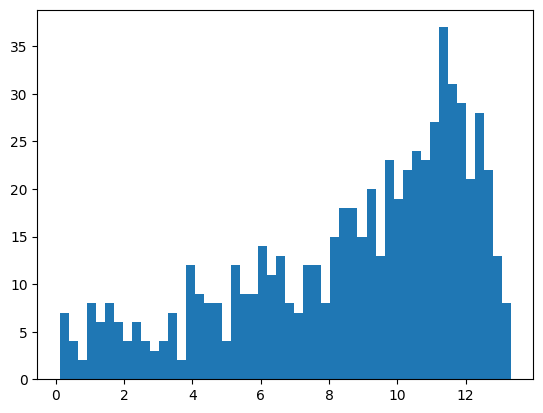

109
357


In [76]:
plt.hist(time_to_cvd_death, bins = 50)
plt.show()
print(sum(time_to_cvd_death < 5))
print(sum(time_to_cvd_death < 10))

In [83]:
len(df[(df['cholesterol lowering medication'] == 0) & (df['statin before admission'] == 1)])

465

In [84]:
len(df[(df['bp medication'] == 0) & (df['antihypertensive before admission'] == 1)])

1293

In [85]:
df['cholesterol lowering medication'] = 1 if df['statin before admission'] == 1 else df['cholesterol lowering medication']

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [ ]:
df['bp medication'] = 1 if df['antihypertensive before admission'] == 1 else df['bp medication']

In [116]:
df = df.dropna(subset =["rank", "hdl"])

In [117]:
#inverse the rank as a higher mdi correlates to a lower ses woa score
recalc = 101-df["rank"]
recalc = recalc.array
recalc = recalc.reshape(-1,1)
#transform rank to seswoa
#SES-WOA minimum and maximum
scaler = MinMaxScaler(feature_range = (-1.617, 0.749))
scaler.fit(recalc)
df["seswoa"] = scaler.transform(recalc)
finaldf = df[["eid", "sex", "age", "sbp", 'total cholesterol','hdl',"seswoa", "rank",
              "champscore", "eetscore", "current_smokers", "ex_smokers", "diabetes",
              "cholesterol lowering medication", "bp medication", "insulin",
              "non fatal CVD event 5 years", "CVD death 5 years",  
              "non fatal CVD event 10 years", "CVD death 10 years",
              "CVD event 5 years", "CVD event 10 years", 
              "dropout", "death other causes 5 years", "death other causes 10 years",
              "prior CVD", "statin_initiation_date", "antihypertensive_initiation_date"]]
#rename some collumns to work with the classifier file
finaldf = finaldf.rename(columns = {"current_smokers": "current smokers", "ex_smokers": "ex smokers",  "cholesterol lowering medication": "cholesterol medication"})

In [118]:
#export the file
finaldf.to_csv("ukbiobankinstance{}.csv".format(instance), index = False)

In [119]:
finaldf['non fatal CVD event 5 years'].value_counts()

0    30733
1      469
Name: non fatal CVD event 5 years, dtype: int64

In [120]:
finaldf['CVD death 5 years'].value_counts()

0    31111
1       91
Name: CVD death 5 years, dtype: int64

In [121]:
finaldf['non fatal CVD event 10 years'].value_counts()

0    30010
1     1192
Name: non fatal CVD event 10 years, dtype: int64

In [122]:
finaldf['CVD death 10 years'].value_counts()

0    30894
1      308
Name: CVD death 10 years, dtype: int64

In [123]:
finaldf['CVD event 5 years'].value_counts()

0    30681
1      521
Name: CVD event 5 years, dtype: int64

In [124]:
finaldf['CVD event 10 years'].value_counts()

0    29829
1     1373
Name: CVD event 10 years, dtype: int64

In [125]:
sum(finaldf['CVD event 5 years'])/len(finaldf['CVD event 5 years'])

0.016697647586693162